## 0 - Librairies

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import BatchNormalization, RandomRotation, RandomTranslation, RandomZoom, RandomBrightness, Input, Add, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, clone_model, Model
from tensorflow.config import run_functions_eagerly

In [24]:
run_functions_eagerly((True))

## 1 - Data Preparation

In [25]:
X_train = np.load("Images/train_images.npy") 
y_train = np.load("Images/train_labels.npy") 
X_test = np.load("Images/test_images.npy")  
y_test = np.load("Images/test_labels.npy")  

In [26]:
print(f'Shape of data X_train:{X_train.shape}\n')
print(f'Shape of data y_train:{y_train.shape}\n')
print(f'Shape of data X_test:{X_test.shape}\n')
print(f'Shape of data y_test:{y_test.shape}')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data y_train:(60000,)

Shape of data X_test:(10000, 28, 28, 1)

Shape of data y_test:(10000,)


In [27]:
# Normalize images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [28]:
# Reshape images for ResNet model
X_train_resnet = X_train.reshape(-1, 28, 28, 1)
X_test_resnet = X_test.reshape(-1, 28, 28, 1)

## 2 - Data Viz

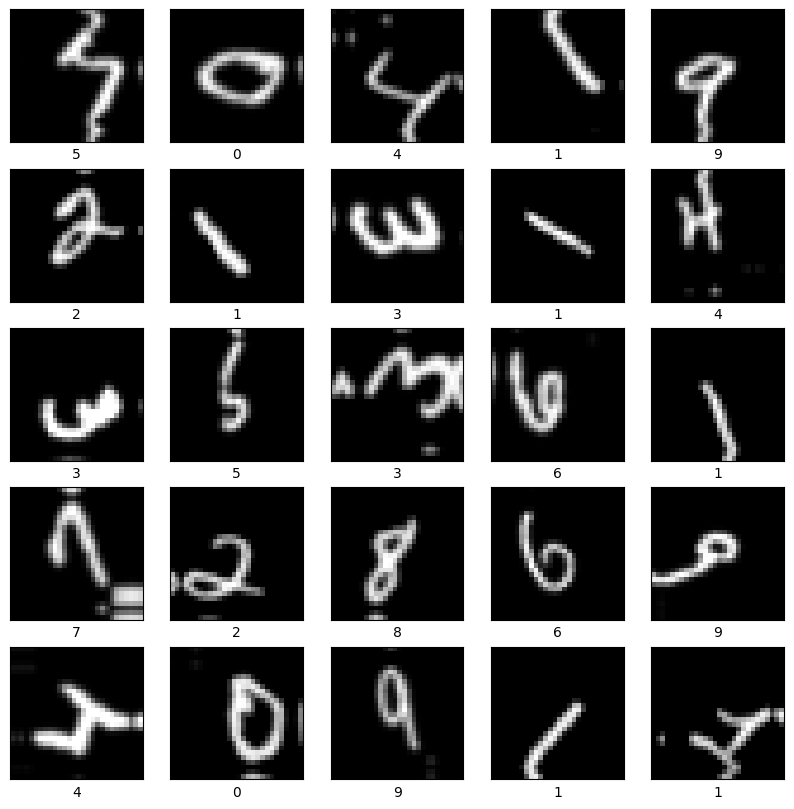

In [29]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.xlabel(y_train[i])
plt.show()

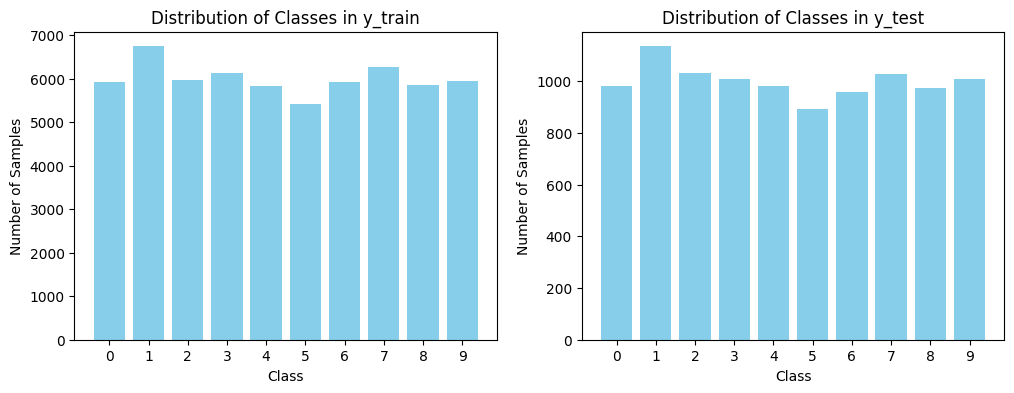

In [30]:
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(unique_classes_train, counts_train, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_train')
plt.xticks(unique_classes_train)  

plt.subplot(1, 2, 2)
plt.bar(unique_classes_test, counts_test, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_test')
plt.xticks(unique_classes_test)  
plt.show()

## 3 - Dense Modele

### Parameters

In [ ]:
# Parameters
epochs_resnet = 20
batch_size_resnet = 100
validation_split_resnet = .2
early_stop_resnet = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, mode="min")
k_folds = 5
learning_rate_resnet = 0.001
metric_resnet = "accuracy"  #"SparseCategoricalAccuracy"

### Modele

In [ ]:
def residual_block(input, input_channels=None, output_channels=None, kernel_size=(3, 3), stride=1):
    if output_channels is None:
        output_channels = input.shape[-1]

    if input_channels is None:
        input_channels = output_channels // 4

    strides = (stride, stride)

    x_shortcut = input
    x = BatchNormalization()(input)
    # x = Activation('relu')(x)
    # x = Conv2D(input_channels, (1, 1))(x)
    # x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(input_channels, kernel_size, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(output_channels, (1, 1), padding='same')(x)

    if input_channels != output_channels or stride != 1:
        x_shortcut = Conv2D(output_channels, (1, 1), padding='same', strides=strides)(x_shortcut)

    output = Add()([x, x_shortcut])

    return output


def create_resnet_model(input_shape=(28, 28, 1), num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Residual bloc 1
    x = residual_block(x, input_channels=16, output_channels=32)
    x = MaxPooling2D((2, 2))(x)

    # Residual bloc 2
    x = residual_block(x, input_channels=32, output_channels=32)
    x = MaxPooling2D((2, 2))(x)

    # Pooling global
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate_resnet),
                  loss='sparse_categorical_crossentropy',
                  metrics=[metric_resnet])
    return model

In [ ]:
skf = StratifiedKFold(n_splits=k_folds, shuffle=True)
fold_results = []
best_resnet_model = None
best_accuracy = 0.0
best_resnet_history = None
histories_resnet = []

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_resnet, y_train)):
    print(f"\nFold {fold + 1}/{k_folds}")
    X_train_fold, X_val_fold = X_train_resnet[train_idx], X_train_resnet[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # New model for the current fold
    resnet_model = create_resnet_model()

    # Train the model
    history = resnet_model.fit(
        X_train_fold, y_train_fold,
        epochs=epochs_resnet,
        batch_size=batch_size_resnet,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stop_resnet],
        verbose=1
    )

    histories_resnet.append(history)

    # Evaluate the model
    val_loss, val_accuracy = resnet_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for fold {fold + 1}: {val_accuracy:.4f}")

    # Store the results
    fold_results.append(val_accuracy)

    # Keep the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_resnet_model = resnet_model
        best_resnet_history = history

# Print the result
print("\nCross-validation results:")
for i, accuracy in enumerate(fold_results):
    print(f"Fold {i + 1}: Validation accuracy = {accuracy:.4f}")
print(f"\nBest validation accuracy: {best_accuracy:.4f}")

# Retourner le meilleur modèle
print("\nBest model summary:")
best_resnet_model.summary()


Fold 1/5


UnboundLocalError: cannot access local variable 'x' where it is not associated with a value

### Results

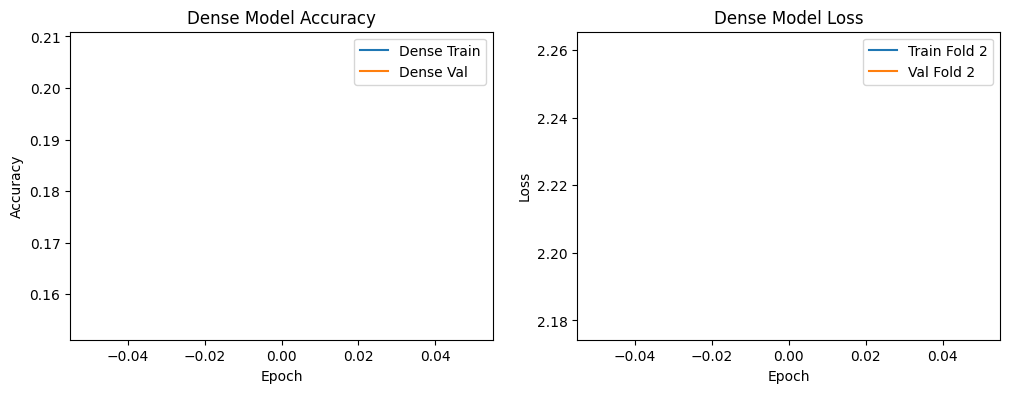

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_resnet_history.history[metric_dense], label='Dense Train')
plt.plot(best_resnet_history.history['val_' + metric_dense], label='Dense Val')
plt.title('Dense Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(best_resnet_history.history['loss'], label=f'Train Fold {i+1}')
plt.plot(best_resnet_history.history['val_loss'], label=f'Val Fold {i+1}')
plt.title('Dense Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Predict classes using the dense model
y_pred_resnet = best_resnet_model.predict(X_test_flat)
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


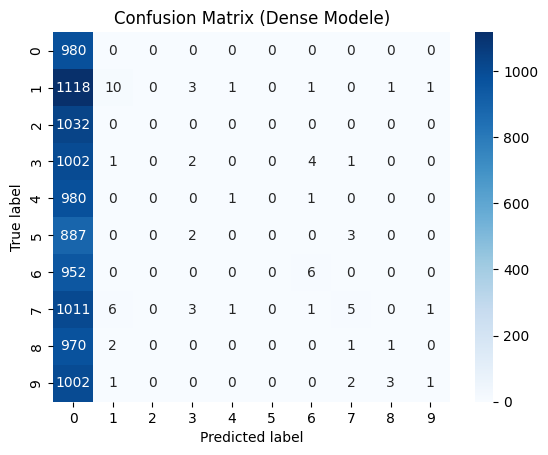

Class 0:
  Sensitivity (SEV): 1.0000
  Specificity (SPE): 0.0073

  Accuracy: 0.1046
  F1-score: 0.1796

Class 1:
  Sensitivity (SEV): 0.0088
  Specificity (SPE): 0.9989

  Accuracy: 0.8865
  F1-score: 0.0173

Class 2:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000

  Accuracy: 0.8968
  F1-score: 0.0000

Class 3:
  Sensitivity (SEV): 0.0020
  Specificity (SPE): 0.9991

  Accuracy: 0.8984
  F1-score: 0.0039

Class 4:
  Sensitivity (SEV): 0.0010
  Specificity (SPE): 0.9998

  Accuracy: 0.9017
  F1-score: 0.0020

Class 5:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000

  Accuracy: 0.9108
  F1-score: 0.0000

Class 6:
  Sensitivity (SEV): 0.0063
  Specificity (SPE): 0.9992

  Accuracy: 0.9041
  F1-score: 0.0124

Class 7:
  Sensitivity (SEV): 0.0049
  Specificity (SPE): 0.9992

  Accuracy: 0.8970
  F1-score: 0.0096

Class 8:
  Sensitivity (SEV): 0.0010
  Specificity (SPE): 0.9996

  Accuracy: 0.9023
  F1-score: 0.0020

Class 9:
  Sensitivity (SEV): 0.0010
  Specificity (SPE

In [ ]:
# Confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes_resnet)  # Compare true labels (y_test) and predicted labels (y_pred_classes_dense)

# Plot confusion matrix
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Dense Modele)')
plt.show()

# Calculate Sensitivity (SEV) and Specificity (SPE) for each class
for i in range(matrix.shape[0]):
    tp = matrix[i, i]
    fn = np.sum(matrix[i, :]) - tp
    fp = np.sum(matrix[:, i]) - tp
    tn = np.sum(matrix) - tp - fn - fp
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
    sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    accuracy = (tn + tp) / (tp + fn + tn + fp)
    print(f'Class {i}:')
    print(f'  Sensitivity (SEV): {sev:.4f}')
    print(f'  Specificity (SPE): {spe:.4f}\n')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-score: {f1:.4f}\n')

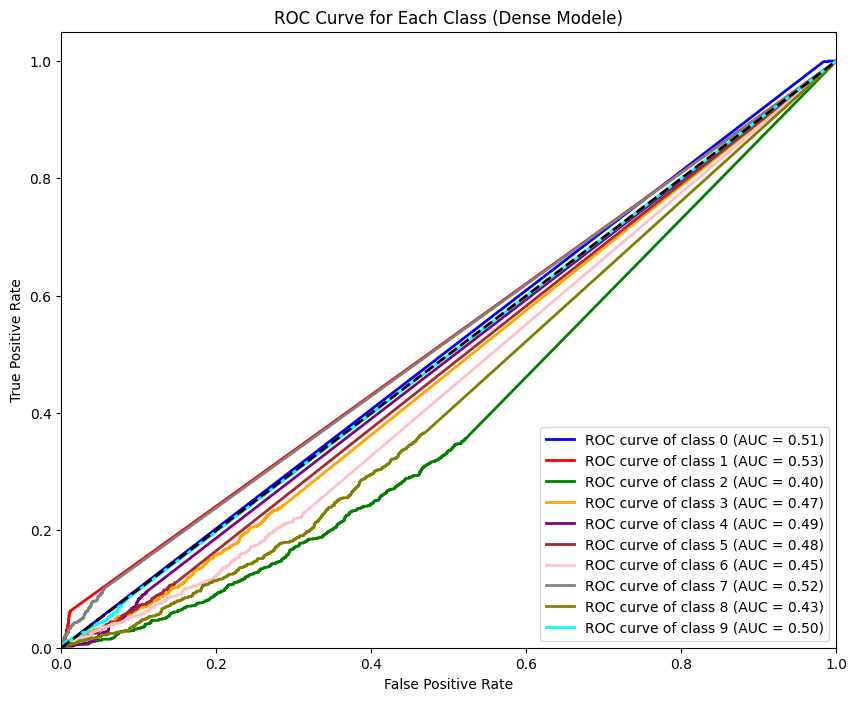

In [ ]:
# Binarize the output for ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_dense[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (Dense Modele)')
plt.legend(loc="lower right")
plt.show()